# Develop Corcovado Shape Estimator

Research and development phase of a class to estimate shape of galaxy stellar mass cluster distribution.

 - 30 min Challenge: class and display function

In [1]:
import matplotlib.pyplot as plt
from astropy import units as u
import numpy as np

In [2]:
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.283)
Msol = 1.98847e33
Mpc2cm = 3.086e+24
z=0.1
rhoc = cosmo.critical_density(z)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
rhoc.to(u.Msun/u.Mpc**3)

<Quantity 1.48731815e+11 solMass / Mpc3>

## Develop Corcovado Shape Class

In [1016]:
from halotools.empirical_models import PrebuiltHodModelFactory
from scipy.integrate import simps
import numpy as np

from projector import radec_to_xy

### Define Cosmology
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
H0 = 70
cosmo = FlatLambdaCDM(H0=H0, Om0=0.283)

rad2deg = 180.0/np.pi

class corcovadoShape:
    """This class estimates shape of a given stellar mass cluster distribution
    """
    def __init__(self, coords=[0,0], z=0, sigma_bg=0) -> None:
        """__init__ Corcovado Shape Measurements Tools

        Estimates the shape of a given stellar mass cluster distribution.

        Parameters
        ----------
        coords : list, optional
            ra, dec of the center of the distribution, by default [0,0]
        z : int, optional
            redshift of the cluster, by default 0
        sigma_bg : int, optional
            background density, by default 0
        """
        self.coords = coords
        self.z = z
        self.sigma_bg = sigma_bg
        self.angularDiameter= cosmo.luminosity_distance(z).value/(1+z**2) ## angular diamteter at redshift z
        self.Mpc2theta = self.angularDiameter/rad2deg # conversion factor to degrees
        
        
    def display(self, rmax=3, kind='points', save=False, ax=None):
        """display point density

        Display cutout of the point distribution

        Parameters
        ----------
        rmax : int, optional
            max size of the box, by default 3
        kind : str, optional
            display can be only points or a colored kernel distribtuion, by default 'points'
        """
        if ax is None: ax = plt.gca()
        if kind=='points':
            plot_points(self.dx_weights, self.dy_weights, rmax, save=save, ax=ax)
        if kind=='kde':
            plot_kde(self.dx_weights, self.dy_weights, rmax, save=save, ax=ax)
            
        pass
    
    def load_sky_coord(self, ra, dec, weights=None, norm_value=1/10):
        """load_sky_coord 

        Converts sky coordinates to physical coords system in Mpc

        Parameters
        ----------
        ra : array
            right ascension
        dec : array
            declination
        weights : array, optional
            weighted value for the point distribution, by default None
            
        Returns
        ----------
        dx : array
            x offset from the center
        dy : array
            y offset from the center
        """
        ra_center, dec_center = self.coords
        
        dx,dy,albers = radec_to_xy(ra, dec, ra_center, dec_center,
                                   self.Mpc2theta) ## Mpc
        # dx and dy in Mpc not Mpc/h
        self.dx = np.array(dx)-np.average(dx,weights=weights)
        self.dy = np.array(dy)-np.average(dy,weights=weights)
        
        if weights is not None:
            self.weight_xy(weights, norm_value=norm_value)
        pass
    
    def weight_xy(self, weights, norm_value=1/10):
        """add_weights

        Weights xy quantities.
        Repeats xy values n times the weights.
        Solution proposed at stackOverflow: 
        https://stackoverflow.com/questions/11442962/python-package-that-supports-weighted-covariance-computation
        
        Parameters
        ----------
        weights : array
            weights values to repeat the xy quantities.
        """
        if not isinstance(np.sum(weights), int):
            self.weights = np.array(weights/norm_value).astype(int)
        
        points = self.make_blobs()
        self.dx_w = points[0]
        self.dx_w = points[0]
        self.points = points
        
        #self.dx_w = np.repeat(self.dx, self.weights, axis=0)
        #self.dy_w = np.repeat(self.dy, self.weights, axis=0)
    
    def make_blobs(self):
        xnew = np.zeros(np.sum(self.weights))
        ynew = np.zeros(np.sum(self.weights))
        ilow = 0
        ihig = 0
        for i in range(self.dx.size):
            ihig += self.weights[i]
            scale = (self.weights[i]/1000.)**(1.5)
            xnew[ilow:ihig] = self.dx[i]+scale*np.random.normal(size=self.weights[i])
            ynew[ilow:ihig] = self.dy[i]+scale*np.random.normal(size=self.weights[i])
            ilow += self.weights[i]
        
        return np.vstack([xnew,ynew]).T
        
    def add_mask(self,mask):
        self.mask = mask
        self.mask_w = np.repeat(mask, self.weights, axis=0)
        
    def load(self, x, y, weights=None):
        """load dataset

        load point distribution

        Parameters
        ----------
        x : array
            x-coordinates
        y : array
            y-coordiantes 
        weights : array, optional
            weighted value for the point distribution, by default None
        """
        pass
    
    def fit(self):
        """fit shape distribution

        Uses the PCA to find the major and minor axis. 
        Converts the results to polar coordinates, eccentricity and position angle.
        """
        pass
    
    def fit_outliers(self, **kwargs):
        """mask_outliers detection algorithm

        Finds the outliers galaxies in the field. 
        Uses the LocalOutlierFactor function from sklearn.
        For the key word arguments (kwargs) take a look at the documentation 
        https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor
        """
    pass

In [1238]:
cat[100:]

Yang,RA,DEC,redshift,N200,logM200c,logM200m,R200c,R200m,thetaR200,thetaR200m,vcirc_c,vcirc_m
int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64
374,245.7299,23.8919,0.06300000101327896,31,14.254902839660645,14.415224322724123,1.1428571939468384,1.5110330058868562,0.18295675929400199,0.24189698559587114,822.2749633789062,764.0497213265847
222,242.8492,36.995,0.06700000166893005,23,14.254902839660645,14.414384873396846,1.1428571939468384,1.5043988031529953,0.17282760569637368,0.227501434376209,822.7521362304688,764.992822466246
394,199.144,7.0911,0.04899999871850014,25,14.264901161193848,14.428359779693885,1.1571428775787354,1.5467147024595083,0.23434214488647112,0.3132374171412896,826.9444580078125,766.6924949865825
310,160.312,33.8973,0.08299999684095383,24,14.264901161193848,14.421219464494552,1.1428571939468384,1.489968685594978,0.1420869109470273,0.18524191419067418,831.0362548828125,774.7606946857126
371,181.3786,43.1855,0.05299999937415123,24,14.27490234375,14.4376686381423,1.1714285612106323,1.5518876726100725,0.2203518984997614,0.29191826650069036,833.792724609375,773.6608124290069
295,131.8533,53.8186,0.04500000178813934,30,14.27490234375,14.439386085179251,1.1714285612106323,1.5658308504771477,0.25712247515759035,0.34369172588443175,832.8416137695312,771.7329432207382
...,...,...,...,...,...,...,...,...,...,...,...,...
26,258.2267,64.0514,0.08100000023841858,150,15.294901847839355,15.452727487036949,2.528571367263794,3.2947002574800357,0.32139699993550314,0.4187766965514693,1831.5782470703125,1708.4498092257656
47,241.306,16.4602,0.04399999976158142,232,15.304902076721191,15.471677995199613,2.5714285373687744,3.461449033114817,0.5765699657760479,0.7761318457776841,1835.83642578125,1703.5562271467647


## Validate on TNG


In [641]:
import sys
sys.path.append('/Users/jesteves/Documents/GitHub/galaxyFormation/scripts')
from file_loc import FileLocs

In [58]:
fl = FileLocs(dataset='sdss', root='/Users/jesteves/Documents/GitHub/galaxyFormation/data/')
cat = fl.load_catalogs('cluster/main')
gal0 = fl.load_catalogs('galaxy/main')

mask  = (gal0['VLOS_MASK']).astype(bool)
mask &= gal0['MAG_TH_MASK'].astype(bool)
gal = gal0[mask]

Loading Catalog: /Users/jesteves/Documents/GitHub/galaxyFormation/data/catalogs/SDSS/groupCatalog_Yang_deCarvalho2017.csv
Loading Catalog: /Users/jesteves/Documents/GitHub/galaxyFormation/data/catalogs/SDSS/groups_deCarvalho2017_5xR200m_galaxies_johnnyheq_pp.csv


In [872]:
gid = gal['Yang']
smass = gal['mass']
rm = gal['Rm']
rv = (gal['Rm']*gal['R200m'])
ra = gal['ra']
dec = gal['dec']
gr = gal['mg']-gal['mr']
po = gal['p_orbital']

orbitall = np.where(gal['orbital']=='False',False, True)
interlopers = np.where(gal['interlopers']=='False',False, True)
infall = np.where(gal['infall']=='False',False, True)

field = (interlopers)

In [60]:
def compute_background_denstiy(idx):
    x = rm[idx]
    y = 10**smass[idx]
    rb = np.percentile(x,[0,100])
    area = np.pi*(np.max(rv[idx])**2 - np.min(rv[idx])**2)
    sigmabg = np.log10(np.sum(y)/area)
    
    sigmabg = np.where(np.isfinite(sigmabg),sigmabg,10.3)
    #sigmabg = np.log10(np.sum(10**smass[field]/(area[field])))
    print('Stellar Mass Background Density Contamination %.2f [M$_{\odot}$/Mpc^2]'%(sigmabg))
    return sigmabg

In [1198]:
keys = [np.where((gid==cid)& (rv <= 5.))[0] for cid in np.array(cat['Yang'])]
# keys_bkg = [np.where((gid==cid) & (rm<=4) & (rm>3) & field)[0] for cid in np.array(cat['Yang'])]

# sigma_bkg = np.array([compute_background_denstiy(ix) for ix in keys_bkg])


In [1267]:
# for a given cluster
# cid = 26
# cid = 12
cid = 295
# idx = np.where(gid==cid)[0]
ra_cls = float(cat['RA'][cat['Yang']==cid])
dec_cls = float(cat['DEC'][cat['Yang']==cid])
zcls = float(cat['redshift'][cat['Yang']==cid])
m200c = float(cat['logM200c'][cat['Yang']==cid])
r200c = float(cat['R200c'][cat['Yang']==cid])
sbg = float(sigma_bkg[cat['Yang']==cid])

idx = keys[int(np.where(cat['Yang']==cid)[0])]

(array([8., 7., 2., 1., 2., 4., 2., 1., 3., 5.]),
 array([0.1706991 , 0.65267907, 1.13465905, 1.61663903, 2.09861901,
        2.58059899, 3.06257896, 3.54455894, 4.02653892, 4.5085189 ,
        4.99049888]),
 <BarContainer object of 10 artists>)

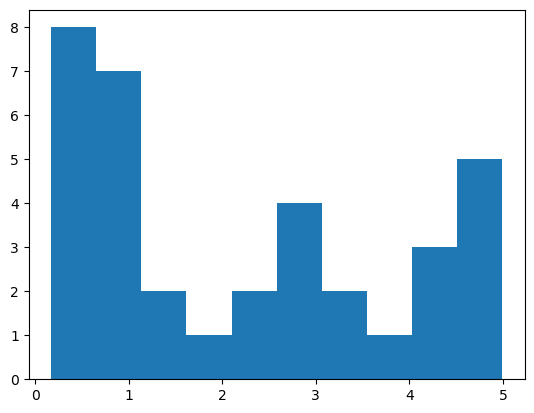

In [1268]:
plt.hist(rv[idx])

## Starting Testing

In [1269]:
help(corcovadoShape)

Help on class corcovadoShape in module __main__:

class corcovadoShape(builtins.object)
 |  corcovadoShape(coords=[0, 0], z=0, sigma_bg=0) -> None
 |  
 |  This class estimates shape of a given stellar mass cluster distribution
 |  
 |  Methods defined here:
 |  
 |  __init__(self, coords=[0, 0], z=0, sigma_bg=0) -> None
 |      __init__ Corcovado Shape Measurements Tools
 |      
 |      Estimates the shape of a given stellar mass cluster distribution.
 |      
 |      Parameters
 |      ----------
 |      coords : list, optional
 |          ra, dec of the center of the distribution, by default [0,0]
 |      z : int, optional
 |          redshift of the cluster, by default 0
 |      sigma_bg : int, optional
 |          background density, by default 0
 |  
 |  add_mask(self, mask)
 |  
 |  display(self, rmax=3, kind='points', save=False, ax=None)
 |      display point density
 |      
 |      Display cutout of the point distribution
 |      
 |      Parameters
 |      ----------
 |   

In [1270]:
cS = corcovadoShape(coords = [ra_cls,dec_cls], z=zcls, sigma_bg=sbg)

In [1271]:
norm = np.mean(po[idx]*10**smass[idx])
cS.load_sky_coord(ra[idx], dec[idx], weights=po[idx]*10**smass[idx], norm_value=int(1e8))

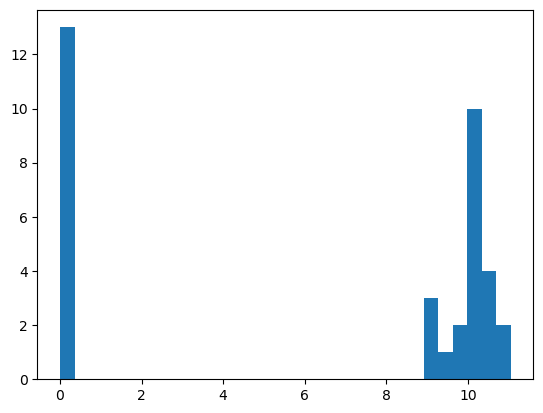

In [1272]:
_ = plt.hist(np.log10(po[idx]*10**smass[idx]+1.),bins=31)

In [1273]:
cS.add_mask(orbitall[idx])#|infall[idx])

In [1274]:
area = (5/0.7)**2
fsbg = ((area)*10**sbg/1e9)/np.sum(cS.weights[cS.mask])
print(f'contamination fraction: {fsbg:.3f}')

contamination fraction: 0.367


In [1275]:
fsbg = np.where(fsbg>0.5,0.5,fsbg)
X_train = cS.points#np.vstack([cS.dx_w, cS.dy_w]).T
X = np.vstack([cS.dx, cS.dy]).T
X_train.shape

(4747, 2)

In [1279]:
from sklearn.ensemble import IsolationForest
lof = IsolationForest(contamination=fsbg, random_state=42, bootstrap=True)
lof.fit(X_train)
cS.outliers = lof.predict(X_train)==-1

In [1280]:
xx, yy = np.meshgrid(np.linspace(-rmax, rmax, 150), np.linspace(-rmax, rmax, 150))
Z = lof.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

(-2.0, 2.0)

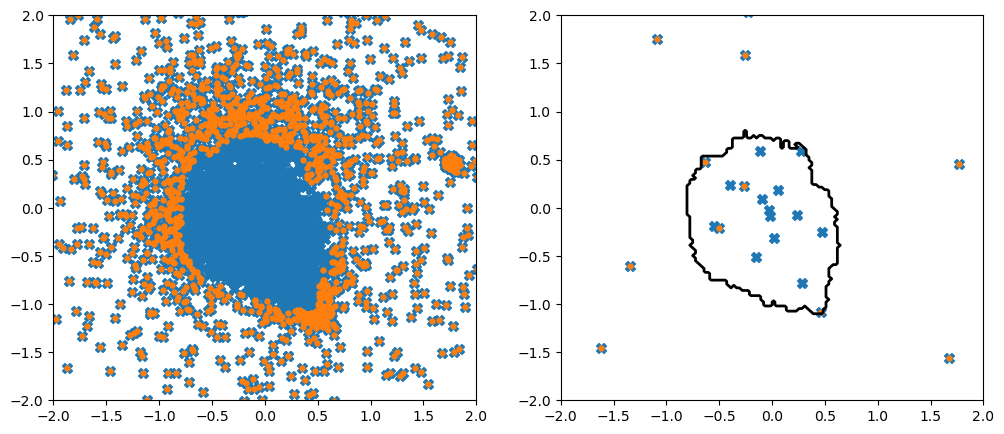

In [1281]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

# axs[0].scatter(cS.dx,cS.dy,s=50,marker='X')
axs[0].scatter(cS.points[:,0],cS.points[:,1],s=50,marker='X')
axs[0].scatter(cS.points[cS.outliers,0],cS.points[cS.outliers,1],s=50,marker='.')
# axs[0].scatter(cS.dx[cS.outliers],cS.dy[cS.outliers],s=50,marker='.')
# axs[0].contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

axs[1].scatter(cS.dx,cS.dy,s=50,marker='X')
axs[1].scatter(cS.dx[~cS.mask],cS.dy[~cS.mask],s=50,marker='.')
axs[1].contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

rmax = 2.
axs[0].set_xlim(-rmax, rmax)
axs[1].set_xlim(-rmax, rmax)

axs[0].set_ylim(-rmax, rmax)
axs[1].set_ylim(-rmax, rmax)

# fig.asp

In [1282]:
# lof.negative_outlier_factor_

In [1283]:
ra_cls, dec_cls

(131.8533, 53.8186)

In [980]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(novelty=True, contamination=0.5, n_neighbors=20)
# lof = LocalOutlierFactor(novelty=True)
lof.fit(X_train)
cS.outliers = lof.predict(X_train)==-1
# cS.outliers = lof.negative_outlier_factor_ <= -0.5

In [965]:
from sklearn.covariance import EllipticEnvelope

lof = EllipticEnvelope(contamination=fsbg)
lof.fit(X_train)
cS.outliers = lof.predict(X_train)==-1

In [951]:
from sklearn.linear_model import SGDOneClassSVM
lof = SGDOneClassSVM(nu=fsbg, shuffle=True, fit_intercept=True,random_state=42,tol=1e-6)
lof.fit(X_train)
cS.outliers = lof.predict(X_train)==-1

In [512]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
X = [[-1.1], [0.2], [101.1], [0.3]]
clf = LocalOutlierFactor(n_neighbors=2)
clf.fit_predict(X)

clf.negative_outlier_factor_

array([ -0.98214286,  -1.03703704, -73.36970899,  -0.98214286])